In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_colwidth', 1000)

In [2]:
df = pd.DataFrame()
for i in range(5):
    file_name = 'data/data_' + str(i) + '.csv'
    df_data = pd.read_csv(file_name)
    df = df.append(df_data)
df = df.reset_index(drop=True)

The label is cost-sensitive, i.e. it's more costly to wrongly classify 2 as 0 than classify 1 as 0.  
One approach to deal with this issue is assigning some class weight to each class, adding the penalty for wrongly classifying label 2.  
In our instance, because tweet with label 1 may add noise and error between different labels, we remove data with label 1 in our data, aiming to forecast 2 in.

In [3]:
df = df.drop(df[df['label'] == 1].index)
# Re-label the 2 to 1
df['label'] = (df['label'] / 2 ).astype(int)

In [4]:
def remove_terms(tweet, keyword, character):
    if keyword:
        for i in keyword:       
            tweet = tweet.replace(character+i.lower(),'')
    return tweet

In [5]:
# Adding feature 'day_after' about 'how many days after the tweet was generate'
# I collect the tweet data on 7 March, so use 35 to substract the day of the tweet
df['day_after'] = 35 - pd.DatetimeIndex(pd.to_datetime(df['date'])).day
# Removing some columns about user information
df = df.drop(columns=['date','link','hour','username','name_x','retweet','location','verified','private','avatar','background_image'])

# 'tweets' column to lowercase
df['tweet'] = df['tweet'].str.lower()

# Transform object type to list
df['hashtags'] = df['hashtags'].apply(lambda x: x.strip('][').split(', ') if x != '[]' else 0)
df['hashtags'] = df['hashtags'].apply(lambda x:[item.strip("'") for item in x] if x != 0 else 0)
screen_name = re.compile("screen_name': '(\w+)'")
df['reply_to'] = df['reply_to'].apply(lambda x:screen_name.findall(x))

# Remove hashtags and reply_to from tweet
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['hashtags'],'#'), axis=1)
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['reply_to'],'@'), axis=1)

# Add a column about 'mention'
screen_name = re.compile("@(\w+)")
df['mention'] = df['tweet'].apply(lambda x:screen_name.findall(x))

# Remove mention from tweet
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['mention'],'@'), axis=1)

# Transform 'reply_to' and 'mention' to int
df['reply_to'] = df['reply_to'].apply(lambda x:len(x) if x != '[]' else 0)
df['mention'] = df['mention'].apply(lambda x:len(x) if x != '[]' else 0)

# Remove photos and video link from tweet
df['tweet'] = df['tweet'].apply(lambda x:re.sub('https://[a-z./0-9]+', '', x))
df['tweet'] = df['tweet'].str.strip()

# Add a column about tweet length
df['tweet_length'] = df['tweet'].apply(lambda x:len(x.split()))

# quote_url is when people quote other's tweets in their tweets.
# Assuming that people quote others tweet is for commenting, not tend to have suicidality
df['quote_url'] = df['quote_url'].astype(str)
df['quote_url'] = df['quote_url'].apply(lambda x: 0 if x=="0" or x=='nan' else 1)

# 'Bio' has NaN value
df['bio'] = df['bio'].replace('\n',' ',regex=True)
df['bio'] = df['bio'].replace('\r',' ',regex=True)

# urls,photos will be classified as 0 or 1
df['urls'] = df['urls'].apply(lambda x: 0 if x == "[]" else 1)
df['photos'] = df['photos'].apply(lambda x: 0 if x == "[]" else 1)

# 'url' is when people put some link on their user profile
df['url'] = df['url'].astype(str)
df['url'] = df['url'].apply(lambda x: 0 if x == 'nan' else 1)

# Concatenate the sentimental analysis
# 0 = negative, 2 = neutral, 4 = positive
df_data = pd.read_csv('data/tweets_sentiment_result.csv')
df_data.columns = ['tweet_sentiment','tweet']
df['tweet_sentiment'] = df_data['tweet_sentiment']

df_data = pd.read_csv('data/bio_sentiment_result.csv')
df_data.columns = ['bio_sentiment','bio']
df['bio_sentiment'] = df_data['bio_sentiment']

# Drop 'bio'
df = df.drop(columns=['bio'])

# change the join_time to '#years user registered a twitter account'
df['join_time'] = 2021 - pd.DatetimeIndex(pd.to_datetime(df['join_date'])).year

df = df.drop(columns=['join_date'])

In [6]:
# investigating 'hashtags'
lst = []
for element in df['hashtags']:
    if element != 0:
        lst += element
hashtags = pd.DataFrame(lst)
hashtags.value_counts().head(5)

mentalhealth                  54
suicidal                      50
suicideprevention             32
depression                    29
turkishstudentslivesmatter    28
dtype: int64

For tweets having suicidal label,  97% of them don't have hashtags.  
We can assume usually people want to raise awareness about suicide may put hashtags.  
Therefore it would be safe to only put numbers of hashtags as feature.  

In [7]:
df['hashtags'] = df['hashtags'].apply(lambda x:len(x) if x != 0 else 0)

#### The pronouns of a tweet
When a tweet is using first-person point of view, it's more likely to refer to the tweet owner's personal feeling, therefore, more likely to be real suicidal thoughts.  
Whereas tweets in second/third person point of view are more like people describing other events.  

In [8]:
first_person = ['i', 'my', 'me', 'am']
df['first_person'] = 0
for word in first_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    first_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['first_person'] = df['first_person'] | first_person_lst
    
second_person = ['you', 'your', 'yours']
df['second_person'] = 0
for word in second_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    second_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['second_person'] = df['second_person'] | second_person_lst
    
third_person = ['he','she',"he's","she's", 'his','her','him','they','them']
df['third_person'] = 0
for word in third_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    third_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['third_person'] = df['third_person'] | third_person_lst

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9238 entries, 0 to 11438
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            9238 non-null   object
 1   label            9238 non-null   int32 
 2   hashtags         9238 non-null   int64 
 3   day              9238 non-null   int64 
 4   urls             9238 non-null   int64 
 5   photos           9238 non-null   int64 
 6   video            9238 non-null   int64 
 7   nlikes           9238 non-null   int64 
 8   nreplies         9238 non-null   int64 
 9   nretweets        9238 non-null   int64 
 10  quote_url        9238 non-null   int64 
 11  reply_to         9238 non-null   int64 
 12  url              9238 non-null   int64 
 13  join_time        9238 non-null   int64 
 14  tweets           9238 non-null   int64 
 15  following        9238 non-null   int64 
 16  followers        9238 non-null   int64 
 17  likes            9238 non-null  

### Feature Engineering

<AxesSubplot:xlabel='mention'>

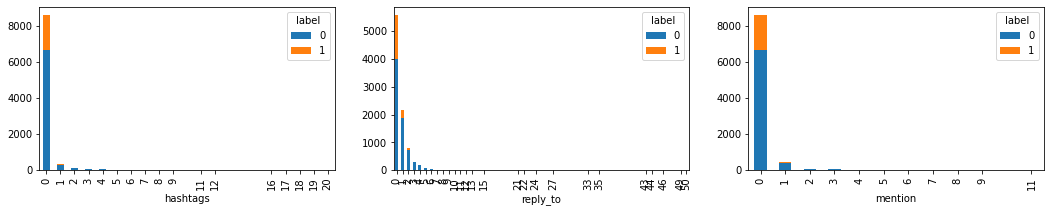

In [10]:
fig, axs = plt.subplots(ncols=3,figsize=(18,3))
df.groupby(['hashtags','label'])['hashtags'].count().unstack().plot(kind='bar',stacked=True,ax=axs[0])
df.groupby(['reply_to','label'])['reply_to'].count().unstack().plot(kind='bar',stacked=True,ax=axs[1])
df.groupby(['mention','label'])['mention'].count().unstack().plot(kind='bar',stacked=True,ax=axs[2])

Since most of the 'hashtags' and 'mention' are empty, we don't they are good features.

<AxesSubplot:xlabel='quote_url'>

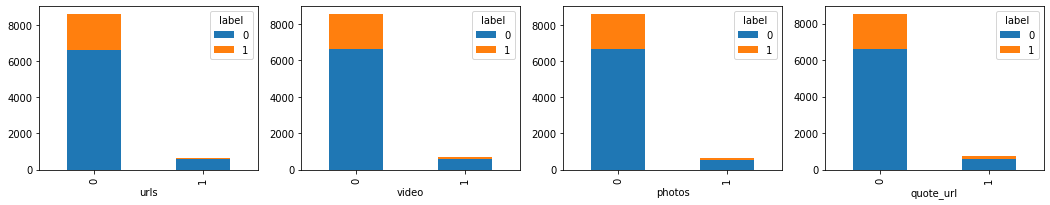

In [11]:
fig, axs = plt.subplots(ncols=4,figsize=(18,3))
df.groupby(['urls','label'])['urls'].count().unstack().plot(kind='bar',stacked=True,ax=axs[0])
df.groupby(['video','label'])['video'].count().unstack().plot(kind='bar',stacked=True,ax=axs[1])
df.groupby(['photos','label'])['photos'].count().unstack().plot(kind='bar',stacked=True,ax=axs[2])
df.groupby(['quote_url','label'])['quote_url'].count().unstack().plot(kind='bar',stacked=True,ax=axs[3])

Seems like most of the media are empty. We could safely drop them.

<AxesSubplot:title={'center':'Not Suicidal People by day'}>

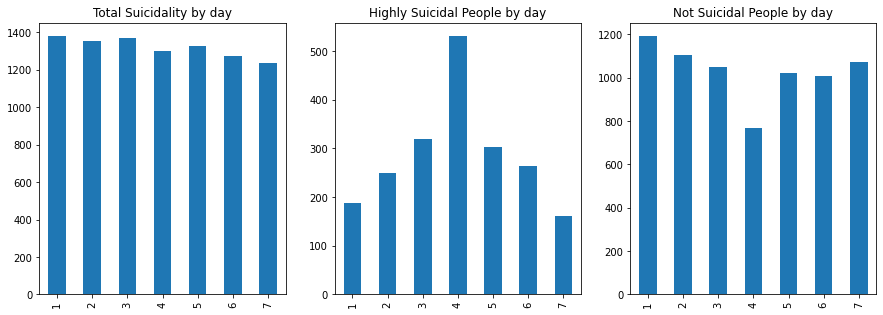

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Total Suicidality by day')
df['day'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,3,2)
plt.title('Highly Suicidal People by day')
df[df['label'] == 1]['day'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,3,3)
plt.title('Not Suicidal People by day')
df[df['label'] == 0]['day'].value_counts().sort_index().plot(kind='bar')

Interesting, how come on Thursday suicidal vibe is so strong?  
We can use the absolute value to map this tendency.  

In [13]:
df = df.drop(columns=['hashtags','mention','quote_url','urls','photos','video'])

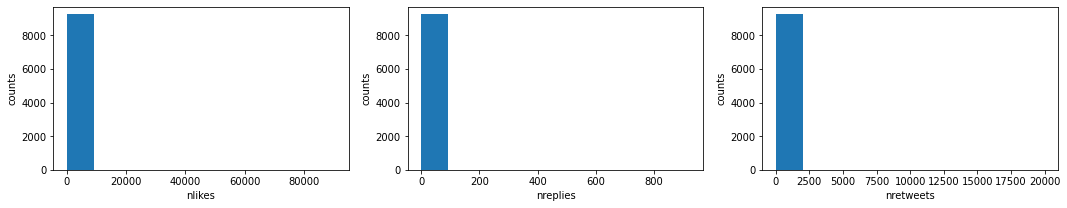

In [14]:
plt.figure(figsize=(18,3))
lst = ['nlikes', 'nreplies', 'nretweets']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(df[lst[i]],bins=10);
    plt.xlabel(lst[i])
    plt.ylabel('counts')

There are some tweets received many likes and replies.  
Those are really outliers, so we apply log to them.

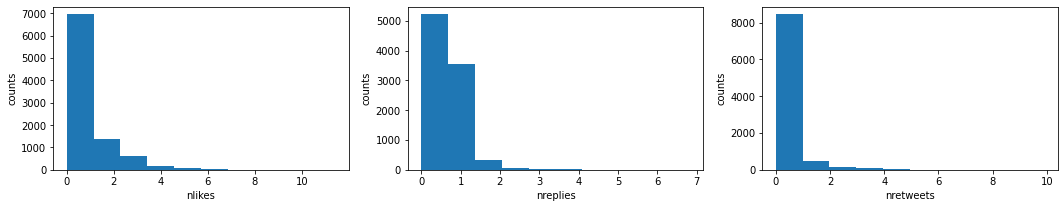

In [15]:
plt.figure(figsize=(18,3))
lst = ['nlikes', 'nreplies', 'nretweets']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(np.log1p(df[lst[i]]),bins=10);
    plt.xlabel(lst[i])
    plt.ylabel('counts')

They are still extremely skewed. 
  
However, 'nlikes','nreplies','nretweets' are features after the tweet sent. We want to detect suicidality as soon as the tweet was sent. So we may consider drop these features when modelling.

Apply the same for other numeric features.

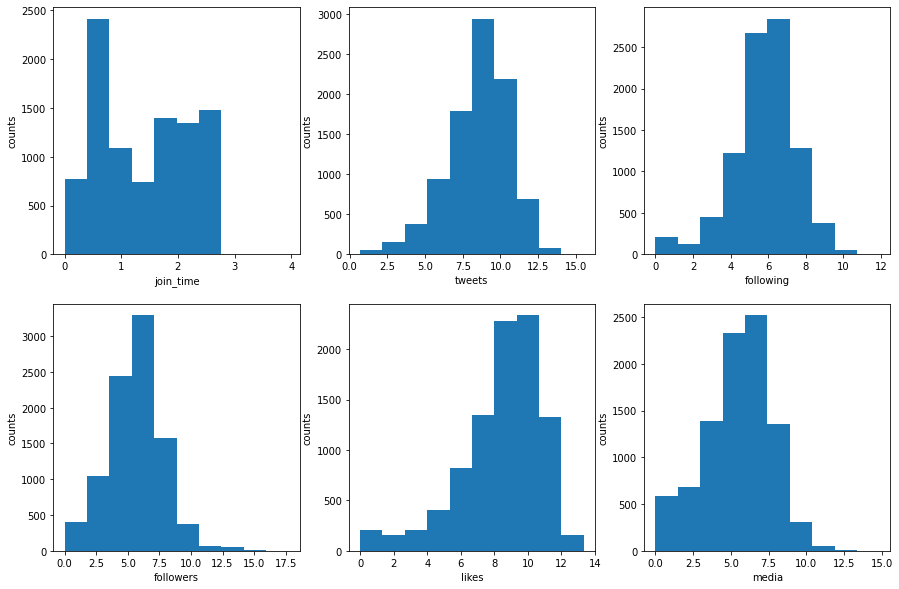

In [16]:
plt.figure(figsize=(15,10))
lst = ['join_time', 'tweets', 'following', 'followers', 'likes', 'media']
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(np.log1p(df[lst[i]]),bins=10);
    plt.xlabel(lst[i])
    plt.ylabel('counts')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9238 entries, 0 to 11438
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            9238 non-null   object
 1   label            9238 non-null   int32 
 2   day              9238 non-null   int64 
 3   nlikes           9238 non-null   int64 
 4   nreplies         9238 non-null   int64 
 5   nretweets        9238 non-null   int64 
 6   reply_to         9238 non-null   int64 
 7   url              9238 non-null   int64 
 8   join_time        9238 non-null   int64 
 9   tweets           9238 non-null   int64 
 10  following        9238 non-null   int64 
 11  followers        9238 non-null   int64 
 12  likes            9238 non-null   int64 
 13  media            9238 non-null   int64 
 14  day_after        9238 non-null   int64 
 15  tweet_length     9238 non-null   int64 
 16  tweet_sentiment  9238 non-null   int64 
 17  bio_sentiment    9238 non-null  

In [18]:
df.to_csv('data/data_after_preprocessing.csv',index=False)

#### Reference: Sentiment analysis through Sentiment140 API

In [ ]:
# Save 'tweet' and 'bio' for sentiment analysis
df['tweet'].to_csv('tweets_for_sentiment.txt',index=False)
df['bio'].to_csv('bio_for_sentiment.txt',index=False)

In [79]:
! curl --data-binary @tweets_for_sentiment.txt "http://www.sentiment140.com/api/bulkClassify?appid=feixie.2020@mitb.smu.edu.sg" > tweets_sentiment_result.csv
! curl --data-binary @bio_for_sentiment.txt "http://www.sentiment140.com/api/bulkClassify?appid=feixie.2020@mitb.smu.edu.sg" > bio_sentiment_result.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 54 1465k    0     0   54  800k      0   800k  0:00:01 --:--:--  0:00:01  914k
100 1465k    0     0  100 1465k      0   732k  0:00:02  0:00:02 --:--:--  710k
100 1465k    0     0  100 1465k      0   488k  0:00:03  0:00:03 --:--:--  478k
100 1465k    0     0  100 1465k      0   366k  0:00:04  0:00:04 --:--:--  359k
100 1465k    0     0  100 1465k      0   293k  0:00:05  0:00:05 --:--:--  287k
100 1465k    0     0  100 1465k      0   244k  0:00:06  0:00:06 --:--:--  127k
100 1465k    0     0  100 1465k      0   209k  0:00:07  0:00:07 --:--:--     0
100 1465k    0     0  100 1465k      0   183k  0:00:08  0:00:08 --:--:--     0
100 1465k    0     0  100 1465k      0   162k  0:00:09  0:00:09 --:--:--     0
100 1465k    0     0  100 1465k      0   146k  0:00